In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV ,Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test2 = pd.read_csv('test.csv')

In [3]:
print(train.shape,test.shape)

(1460, 81) (1459, 80)


In [4]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

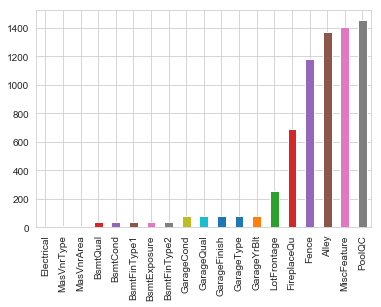

In [5]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

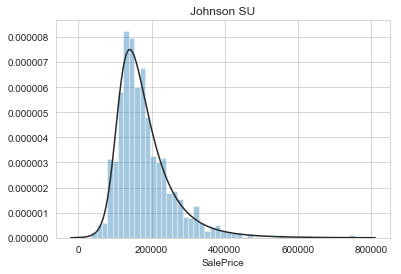

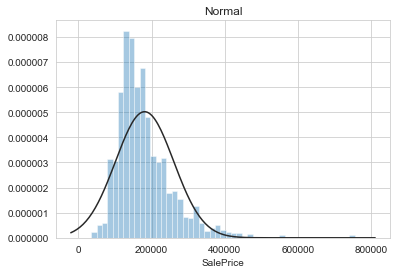

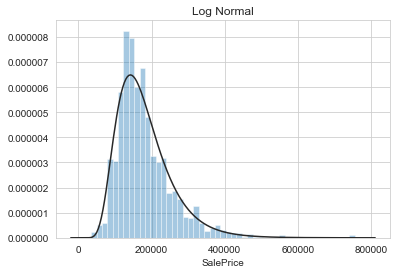

In [6]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

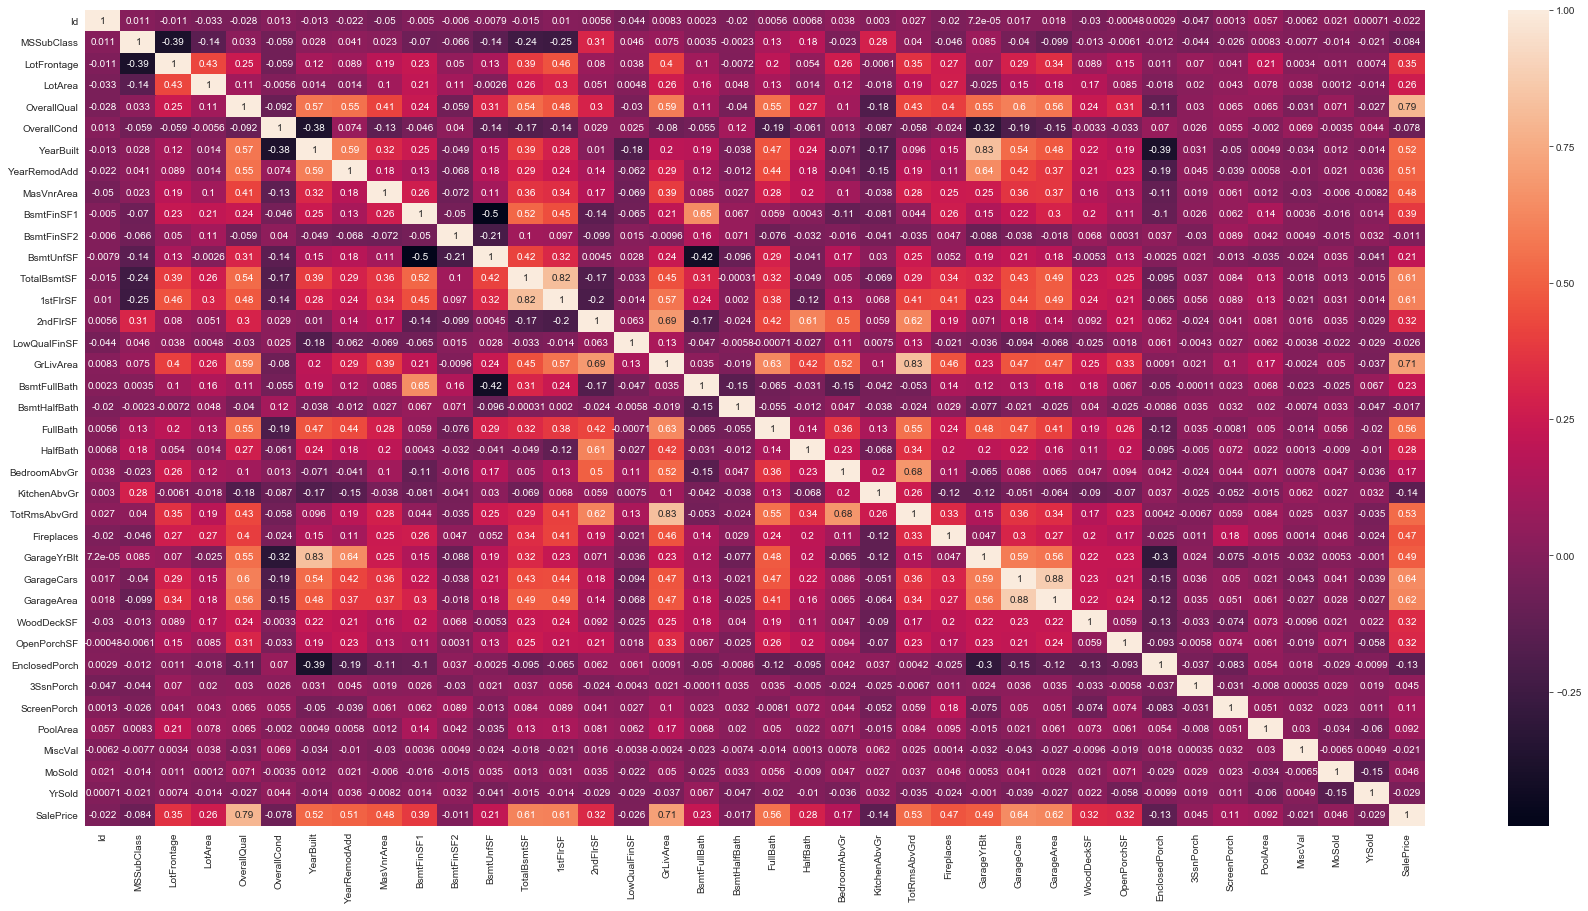

In [7]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr(), annot=True)

In [8]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [9]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

In [10]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [11]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])


In [12]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,None,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,None,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,None,NaN,NaN,0,12,2008,WD,Normal


In [13]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [14]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [15]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [16]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [17]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 332)

In [18]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1458, 332), (1458,), (1459, 332))

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1458,20.673625,14.550688,5,4.679500,1961,1961,0.000000,107.505912,7.760720,42.813710,...,0,0,0,1,0,0,0,0,1,0
1459,20.834996,15.023150,6,4.679500,1958,1958,14.642918,174.393644,0.000000,54.675304,...,0,0,0,1,0,0,0,0,1,0
1460,19.687482,14.950919,5,3.991517,1997,1998,0.000000,156.263694,0.000000,28.375984,...,0,0,0,1,0,0,0,0,1,0
1461,20.348384,14.204773,6,4.679500,1998,1998,6.157403,128.653472,0.000000,47.769036,...,0,0,0,1,0,0,0,0,1,0
1462,13.949260,12.696876,8,3.991517,1992,1992,0.000000,71.179547,0.000000,94.312856,...,0,0,0,1,0,0,0,0,1,0
1463,19.854050,14.209735,6,3.991517,1993,1994,0.000000,0.000000,0.000000,79.571112,...,0,0,0,1,0,0,0,0,1,0
1464,17.967900,13.706331,6,5.348040,1992,2007,0.000000,176.002637,0.000000,39.175106,...,0,0,0,1,0,0,0,0,1,0
1465,17.790097,13.820412,6,3.991517,1998,1998,0.000000,0.000000,0.000000,81.166089,...,0,0,0,1,0,0,0,0,1,0
1466,21.472480,14.249078,7,3.991517,1990,1990,0.000000,133.939428,0.000000,73.212209,...,0,0,0,1,0,0,0,0,1,0
1467,19.011798,13.819884,4,3.991517,1970,1970,0.000000,158.086666,6.434559,0.000000,...,0,0,0,1,0,0,0,0,1,0


In [19]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [20]:
sc=RobustScaler()
X=sc.fit_transform(X)

In [48]:
model=Lasso(alpha =0.001, random_state=1)

In [49]:
model.fit(X,y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [50]:
print('RMSLE score on train data:')
print(rmsle(y, model.predict(X)))

RMSLE score on train data:
0.1017374768340544


In [69]:
submission = pd.read_csv("submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(0.05*model.predict(X_sub)))

In [70]:
submission

,Id,SalePrice
0,1461,2335734.0
1,1462,3394028.0
2,1463,114645321.0
3,1464,96792843.0
4,1465,3556761.0
5,1466,180284732.0
6,1467,3865492.0
7,1468,54744117.0
8,1469,4214019.0
9,1470,2360827.0


In [53]:
submission.to_csv("lasso.csv", index=False)

In [42]:
pred=model.predict(X_sub)
preds=np.exp(pred)
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('tsds.csv', index=False)

In [43]:
output

,Id,SalePrice
0,1461,2.335993e+127
1,1462,4.114463e+130
2,1463,1.538604e+161
3,1464,5.210328e+159
4,1465,1.049778e+131
5,1466,1.315767e+165
6,1467,5.547517e+131
7,1468,5.844527e+154
8,1469,3.118412e+132
9,1470,2.892592e+127
